In [1]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1ccab15c0b89d28d8bae9e18755da5ef2289206a18ca31eb6384918765df3655
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [2]:
import nltk
nltk.download('averaged_perceptron_tagger_eng', quiet=True)


True

In [3]:
# ---------- 1. NLTK ----------
for pkg in ['stopwords','punkt','wordnet','averaged_perceptron_tagger','punkt_tab']:
    nltk.download(pkg, quiet=True)

nltk.download('averaged_perceptron_tagger_eng', quiet=True)

True

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import unicodedata
import random
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
for package in ['stopwords', 'punkt', 'wordnet', 'averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng', 'punkt_tab']:
    try:
        nltk.data.find(f'corpora/{package}')
    except:
        nltk.download(package)

# Initialize lemmatizer and stopwords for preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
print("NLTK data download complete and lemmatizer initialized.")


NLTK data download complete and lemmatizer initialized.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
def get_wordnet_pos(word):
    """Maps NLTK POS tags to WordNet tags for lemmatization."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [7]:
def normalize(text, label):
    """Normalizes text and formats label."""
    text = unicodedata.normalize("NFKC", text.strip().lower())
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words if word not in stop_words]
    text = ' '.join(words)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\b(the (present )?invention (relates|is directed) to)\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', text)
    formatted_label = f'[start] {label} [end]'
    return text, formatted_label

In [8]:
def synonym_replacement(words, n=1):
    """
    Replaces up to 'n' words with synonyms.
    This version correctly handles multiple occurrences of a word.
    """
    new_words = list(words)
    random_word_list = [word for word in new_words if wordnet.synsets(word)]
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = [lemma.name().replace('_', ' ') for syn in wordnet.synsets(random_word) for lemma in syn.lemmas()]
        synonyms = [s for s in synonyms if s != random_word]
        if synonyms and num_replaced < n:
            synonym = random.choice(synonyms)
            # Replace all instances of the word
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
    return new_words

In [9]:
def random_word_deletion(words, p=0.1):
    """
    Deletes words from a list with a given probability p.
    """
    if len(words) < 2:
        return words
    new_words = [word for word in words if random.uniform(0, 1) > p]
    return new_words if new_words else [random.choice(words)]

In [10]:
def generate_augmented_samples(text, label, num_samples=15):
    """
    Generates multiple augmented versions of a single text-label pair.
    """
    augmented_samples = [(text, label)]
    words = text.split()
    for _ in range(num_samples - 1):
        if random.uniform(0, 1) < 0.5:
            new_words = synonym_replacement(words, n=max(1, int(len(words) * 0.1)))
        else:
            new_words = random_word_deletion(words, p=0.1)
        augmented_text = ' '.join(new_words)
        if augmented_text:
            augmented_samples.append((augmented_text, label))
    return augmented_samples

In [11]:
try:
    df = pd.read_excel('Manual Analysis_input.xlsx', skiprows=4)
    df1 = pd.DataFrame()
    df1['combined'] = df[['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']].astype(str).agg(' '.join, axis=1)
    df2 = pd.read_excel('actual labels.xlsx', skiprows=3)
    combine = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

    initial_text_pairs = [normalize(row['combined'], row['Unnamed: 0']) for _, row in combine.iterrows()]

    # Generate all augmented samples, including duplicates.
    text_pairs_augmented = [pair for text, label in initial_text_pairs for pair in generate_augmented_samples(text, label, num_samples=15)]

    # --- ADD THIS NEW BLOCK ---
    # Convert the augmented list to a set to remove duplicate (text, label) pairs.
    unique_text_pairs_set = set(text_pairs_augmented)

    # Convert the set back to a list for further processing.
    text_pairs = list(unique_text_pairs_set)
    # --- END OF NEW BLOCK ---

    random.seed(42)
    random.shuffle(text_pairs)
    n_val = int(0.15 * len(text_pairs))
    train_pairs = text_pairs[n_val:]
    test_pairs = text_pairs[:n_val]

    unique_text_tokens = set()
    unique_label_tokens = set()
    max_text_len_observed = 0
    max_label_len_observed = 0
    for text, label in text_pairs:
        text_split = text.split()
        label_split = label.split()
        unique_text_tokens.update(text_split)
        unique_label_tokens.update(label_split)
        max_text_len_observed = max(max_text_len_observed, len(text_split))
        max_label_len_observed = max(max_label_len_observed, len(label_split))

    vocab_text = len(unique_text_tokens) + 2
    vocab_label = len(unique_label_tokens) + 2
    seq_length = max(max_text_len_observed, max_label_len_observed, 25)
    if seq_length < 64: seq_length = 64
    if seq_length > 256: seq_length = 256

    loaded_text_vec = TextVectorization(max_tokens=20000, split='whitespace', output_mode='int', output_sequence_length=seq_length, standardize='lower_and_strip_punctuation', ngrams=None)
    loaded_label_vec = TextVectorization(max_tokens=20000, split='whitespace', output_mode='int', output_sequence_length=seq_length, standardize=None, ngrams=None)
    loaded_text_vec.adapt([pair[0] for pair in train_pairs])
    loaded_label_vec.adapt([pair[1] for pair in train_pairs])

except Exception as e:
    print(f"Error loading data or applying augmentation: {e}")
    text_pairs = [("hello world", "[start] hello world [end]"), ("how are you doing today", "[start] how are you [end]")]
    train_pairs = text_pairs
    test_pairs = text_pairs
    vocab_text = 100
    vocab_label = 50
    seq_length = 20
    loaded_text_vec = TextVectorization(max_tokens=20000, split='whitespace', output_mode='int', output_sequence_length=seq_length, standardize='lower_and_strip_punctuation', ngrams=None)
    loaded_label_vec = TextVectorization(max_tokens=20000, split='whitespace', output_mode='int', output_sequence_length=seq_length, standardize=None, ngrams=None)
    loaded_text_vec.adapt([pair[0] for pair in train_pairs])
    loaded_label_vec.adapt([pair[1] for pair in train_pairs])

In [12]:
# Save the combined dataframe to an Excel file
combine.to_excel('combined_data.xlsx', index=False)
print("Combined data saved to 'combined_data.xlsx'")

Combined data saved to 'combined_data.xlsx'


In [13]:
train_pairs

[("mush container fuse junction method acting make mould mush container fuse junction method acting make allow for present invention allow for mush container be mould mush consistence wherein consistence be bottom to the lowest degree one slope palisade word form enclosed space wherein to the lowest degree one slope palisade be amphetamine lip neck opening wherein neck opening be amphetamine closure divide humiliated lip fuse junction wherein divide amphetamine lip to the lowest degree one sidewall consistence divide humiliated lip neck opening array fuse together fuse junction may word form supersonic dyer's mignonette ace method acting fabricate mush container method acting be generate offset divide beat wherein offset divide beat be offset lip generate indorse divide beat wherein indorse divide beat be indorse lip laminate Department of the Interior surface to the lowest degree one offset indorse divide beat polymer flick run offset indorse lip array offset indorse divide beat where

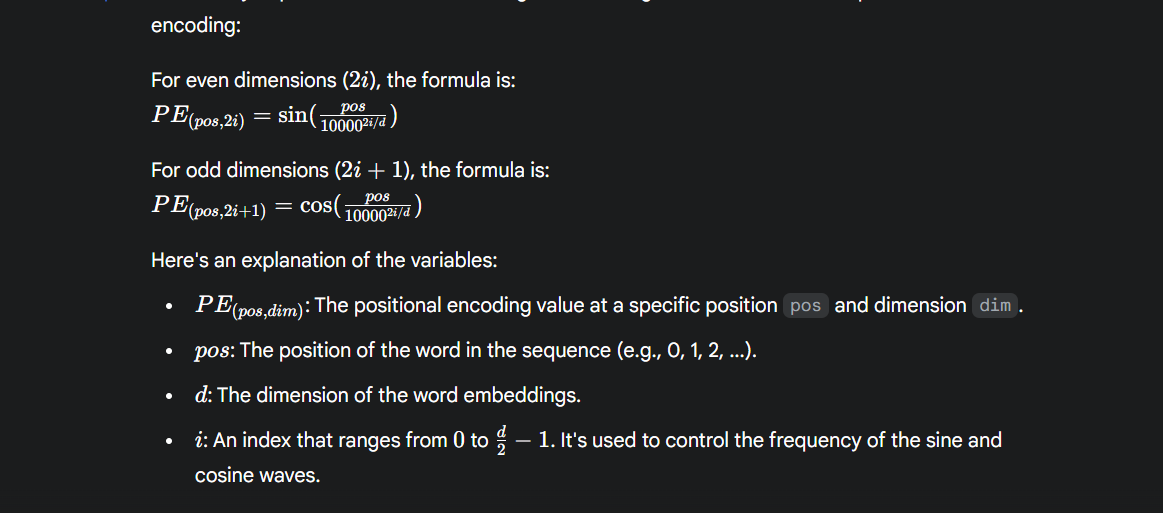

In [14]:
def pos_enc_matrix(L, d, n=10000):
    assert d % 2 == 0
    d2 = d // 2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)
    i = np.arange(d2).reshape(1, -1)
    denom = np.power(n, -i / d2)
    args = k * denom
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

In [15]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, seq_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True, dtype='float32')
        matrix = pos_enc_matrix(seq_length, embed_dim)
        self.positional_embedding = tf.constant(matrix, dtype=tf.float32)

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = tf.cast(embedded_tokens, tf.float32)
        sliced_positional_embedding = self.positional_embedding[:tf.shape(embedded_tokens)[1], :]
        return embedded_tokens + sliced_positional_embedding

    def compute_mask(self, inputs, mask=None):
        return self.token_embeddings.compute_mask(inputs, mask=mask)

    def get_config(self):
        config = super().get_config()
        config.update({'seq_length': self.seq_length, 'vocab_size': self.vocab_size, 'embed_dim': self.embed_dim})
        return config


In [16]:
def scaled_dot_product_attention_manual(query, key, value, dk_val, mask=None):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    dk = tf.cast(dk_val, tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits = tf.where(mask, scaled_attention_logits, -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

In [17]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != embed_dim:
            raise ValueError("embedding_dim should be divisible by num_heads")
        self.wq = tf.keras.layers.Dense(embed_dim, use_bias=False)
        self.wk = tf.keras.layers.Dense(embed_dim, use_bias=False)
        self.wv = tf.keras.layers.Dense(embed_dim, use_bias=False)
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.supports_masking = True
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, inputs, mask=None):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        padding_mask = tf.cast(tf.expand_dims(tf.expand_dims(inputs._keras_mask, 1), 1), dtype=tf.bool) if hasattr(inputs, '_keras_mask') and inputs._keras_mask is not None else None
        q, k, v = self.wq(inputs), self.wk(inputs), self.wv(inputs)
        q, k, v = self.split_heads(q, batch_size), self.split_heads(k, batch_size), self.split_heads(v, batch_size)
        combined_attention_mask = None
        if padding_mask is not None and mask is True:
            causal_mask_tensor = tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=tf.bool), -1, 0)
            causal_mask_tensor = tf.expand_dims(tf.expand_dims(causal_mask_tensor, 0), 0)
            combined_attention_mask = tf.logical_and(padding_mask, causal_mask_tensor)
        elif padding_mask is not None:
            combined_attention_mask = padding_mask
        elif mask is True:
            causal_mask_tensor = tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=tf.bool), -1, 0)
            combined_attention_mask = tf.expand_dims(tf.expand_dims(causal_mask_tensor, 0), 0)
        scaled_attention, _ = scaled_dot_product_attention_manual(q, k, v, self.head_dim, combined_attention_mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embed_dim))
        output = self.dense(concat_attention)
        if hasattr(inputs, '_keras_mask') and inputs._keras_mask is not None:
            output._keras_mask = inputs._keras_mask
        return output
    def get_config(self):
        config = super().get_config()
        config.update({'embed_dim': self.embed_dim, 'num_heads': self.num_heads})
        return config

In [18]:
class MultiHeadCrossAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != embed_dim:
            raise ValueError("embedding_dim should be divisible by num_heads")
        self.wq = tf.keras.layers.Dense(embed_dim, use_bias=False)
        self.wk = tf.keras.layers.Dense(embed_dim, use_bias=False)
        self.wv = tf.keras.layers.Dense(embed_dim, use_bias=False)
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.supports_masking = True
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, inputs):
        query_input, context_input = inputs
        batch_size = tf.shape(query_input)[0]
        query_padding_mask = tf.cast(tf.expand_dims(tf.expand_dims(query_input._keras_mask, 1), -1), dtype=tf.bool) if hasattr(query_input, '_keras_mask') and query_input._keras_mask is not None else None
        context_padding_mask = tf.cast(tf.expand_dims(tf.expand_dims(context_input._keras_mask, 1), 1), dtype=tf.bool) if hasattr(context_input, '_keras_mask') and context_input._keras_mask is not None else None
        attention_mask_for_sdp = tf.logical_and(query_padding_mask, context_padding_mask) if query_padding_mask is not None and context_padding_mask is not None else query_padding_mask if query_padding_mask is not None else context_padding_mask if context_padding_mask is not None else None
        q, k, v = self.wq(query_input), self.wk(context_input), self.wv(context_input)
        q, k, v = self.split_heads(q, batch_size), self.split_heads(k, batch_size), self.split_heads(v, batch_size)
        scaled_attention, _ = scaled_dot_product_attention_manual(q, k, v, self.head_dim, attention_mask_for_sdp)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embed_dim))
        output = self.dense(concat_attention)
        if hasattr(query_input, '_keras_mask') and query_input._keras_mask is not None:
            output._keras_mask = query_input._keras_mask
        return output
    def get_config(self):
        config = super().get_config()
        config.update({'embed_dim': self.embed_dim, 'num_heads': self.num_heads})
        return config

In [19]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, model_dim, ff_dim, dropout=0.2, **kwargs):
        super().__init__(**kwargs)
        self.model_dim = model_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout
        self.dense1 = tf.keras.layers.Dense(ff_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(model_dim)
        self.drop = tf.keras.layers.Dropout(dropout)
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add = tf.keras.layers.Add()
        self.supports_masking = True
    def call(self, inputs):
        input_mask = inputs._keras_mask if hasattr(inputs, '_keras_mask') else None
        ffout = self.drop(self.dense2(self.dense1(inputs)))
        output = self.norm(self.add([inputs, ffout]))
        if input_mask is not None:
            output._keras_mask = input_mask
        return output
    def get_config(self):
        config = super().get_config()
        config.update({'model_dim': self.model_dim, 'ff_dim': self.ff_dim, 'dropout_rate': self.dropout_rate})
        return config

In [20]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = MultiHeadSelfAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = FeedForward(model_dim=embed_dim, ff_dim=ff_dim, dropout=rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.add = tf.keras.layers.Add()
        self.supports_masking = True
    def call(self, inputs, training=False):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(self.add([inputs, attn_output]))
        ffn_output = self.ffn(out1)
        return self.layernorm2(self.add([out1, ffn_output]))
    def get_config(self):
        config = super().get_config()
        config.update({'embed_dim': self.embed_dim, 'num_heads': self.num_heads, 'ff_dim': self.ff_dim, 'rate': self.rate})
        return config


In [21]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.self_att = MultiHeadSelfAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.cross_att = MultiHeadCrossAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = FeedForward(model_dim=embed_dim, ff_dim=ff_dim, dropout=rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.add = tf.keras.layers.Add()
        self.supports_masking = True
    def call(self, x, enc_output, training=False):
        attn1 = self.self_att(x, mask=True)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(self.add([x, attn1]))
        attn2 = self.cross_att([out1, enc_output])
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(self.add([out1, attn2]))
        ffn_output = self.ffn(out2)
        return self.layernorm3(self.add([out2, ffn_output]))
    def get_config(self):
        config = super().get_config()
        config.update({'embed_dim': self.embed_dim, 'num_heads': self.num_heads, 'ff_dim': self.ff_dim, 'rate': self.rate})
        return config

In [22]:
def transformer(num_layers, num_heads, text_seq_length, label_seq_length, embed_dim, ff_dim, vocab_text, vocab_label, dropout=0.2, name='transformer'):
    input_enc = tf.keras.layers.Input(shape=(text_seq_length,), dtype='int64', name='encode_inp')
    # The decoder input layer's shape is now set to the correct length
    input_dec = tf.keras.layers.Input(shape=(label_seq_length,), dtype='int64', name='decode_inp')

    x_enc_emb = PositionalEmbedding(text_seq_length, vocab_text, embed_dim, name='embed_encoders')(input_enc)
    x_dec_emb = PositionalEmbedding(label_seq_length, vocab_label, embed_dim, name='embed_decoders')(input_dec)

    x_enc_emb = tf.keras.layers.Dropout(dropout)(x_enc_emb)
    x_dec_emb = tf.keras.layers.Dropout(dropout)(x_dec_emb)

    encoder_output = x_enc_emb
    for i in range(num_layers):
        encoder_output = EncoderBlock(embed_dim=embed_dim, ff_dim=ff_dim, rate=dropout, num_heads=num_heads, name=f"encoder_block_{i}")(encoder_output)

    decoder_output = x_dec_emb
    for i in range(num_layers):
        decoder_output = DecoderBlock(embed_dim=embed_dim, ff_dim=ff_dim, rate=dropout, num_heads=num_heads, name=f"decoder_block_{i}")(x=decoder_output, enc_output=encoder_output)

    output_logits = tf.keras.layers.Dense(vocab_label, name='linear')(decoder_output)
    if hasattr(output_logits, '_keras_mask'):
        del output_logits._keras_mask
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output_logits, name=name)
    return model

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    def get_config(self):
        config = {'d_model': self.d_model.numpy(), 'warmup_steps': self.warmup_steps}
        return config

In [24]:

import tensorflow as tf
import numpy as np

def top_p_filtering(logits, p=0.9, min_tokens_to_keep=1):
    logits = logits.copy()
    sorted_ids = np.argsort(-logits)
    sorted_logits = logits[sorted_ids]
    probs = np.exp(sorted_logits - np.max(sorted_logits))
    probs = probs / probs.sum()
    cumulative = np.cumsum(probs)
    cutoff_index = np.searchsorted(cumulative, p, side='right')
    cutoff_index = max(cutoff_index, min_tokens_to_keep-1)
    remove_ids = sorted_ids[cutoff_index+1:]
    mask = np.zeros_like(logits, dtype=bool)
    mask[remove_ids] = True
    return mask

def apply_no_repeat_ngram_mask(logits_np, prev_ids, n_gram):
    if n_gram <= 0 or len(prev_ids) < n_gram - 1:
        return np.zeros_like(logits_np, dtype=bool)
    banned = set()
    n_1 = n_gram - 1
    for i in range(len(prev_ids) - n_gram + 1):
        gram = tuple(prev_ids[i:i + n_1])
        next_tok = prev_ids[i + n_1]
        banned.add((gram, next_tok))
    last_gram = tuple(prev_ids[-n_1:]) if n_1 > 0 else tuple()
    mask = np.zeros_like(logits_np, dtype=bool)
    for (gram, tok) in banned:
        if gram == last_gram:
            mask[tok] = True
    return mask

def generate_labels_autoregressive_fixed(model, encoder_input, start_token, end_token, max_len=64,
                                         temperature=1.0, top_p=0.9, repetition_penalty=1.2,
                                         n_gram=3, min_tokens_to_keep=1):
    batch_size = int(tf.shape(encoder_input)[0])
    vocab_size = int(model.outputs[0].shape[-1])
    decoder_input = tf.fill([batch_size, 1], start_token)
    generated = [list() for _ in range(batch_size)]

    for step in range(max_len):
        logits = model([encoder_input, decoder_input], training=False)
        last_logits = logits[:, -1, :]
        last_logits_np = last_logits.numpy()

        next_tokens = []
        for b in range(batch_size):
            logits_b = last_logits_np[b].astype(np.float64)
            if temperature != 1.0 and temperature > 0:
                logits_b = logits_b / temperature
            if repetition_penalty != 1.0:
                for token in set(generated[b]):
                    if logits_b[token] > 0:
                        logits_b[token] = logits_b[token] / repetition_penalty
                    else:
                        logits_b[token] = logits_b[token] * repetition_penalty
            if n_gram > 0 and len(generated[b]) >= n_gram - 1:
                nr_mask = apply_no_repeat_ngram_mask(logits_b, generated[b] + list(decoder_input[b].numpy()[1:]), n_gram)
                logits_b[nr_mask] = -1e9
            remove_mask = top_p_filtering(logits_b, p=top_p, min_tokens_to_keep=min_tokens_to_keep)
            logits_b[remove_mask] = -1e9
            probs = np.exp(logits_b - np.max(logits_b))
            probs = probs / probs.sum()
            sampled = np.random.choice(len(probs), p=probs)
            next_tokens.append(int(sampled))

        next_tokens_arr = np.array(next_tokens, dtype=np.int32).reshape(batch_size, 1)
        decoder_input = tf.concat([decoder_input, tf.convert_to_tensor(next_tokens_arr)], axis=1)
        for b in range(batch_size):
            generated[b].append(next_tokens[b])

        loop_detected = True
        for b in range(batch_size):
            seq = generated[b]
            if len(seq) < 6 or not all(x == seq[-1] for x in seq[-6:]):
                loop_detected = False
                break
        if loop_detected:
            print("Loop detected — breaking generation to avoid repeated tokens.")
            break
        if all(tok == end_token for tok in next_tokens):
            break

    return decoder_input


In [25]:
def generate_labels_autoregressive(model, text_input, start_token, end_token, max_len, p=0.9, repetition_penalty=1.2, n_gram=2):
    """
    Generates a sequence of labels autoregressively using Top-p (Nucleus) sampling and n-gram repetition penalty.
    """
    batch_size = tf.shape(text_input)[0]
    vocab_size = model.inputs[1].shape[-1]
    padding_token = 0

    decoder_input = tf.fill(dims=(batch_size, 1), value=start_token)

    for _ in range(max_len):
        current_seq_len = tf.shape(decoder_input)[1]
        padding_needed = max_len - 1 - current_seq_len
        if padding_needed < 0:
            padding_needed = 0
        padding_shape = [[0, 0], [0, padding_needed]]
        padded_decoder_input = tf.pad(decoder_input, padding_shape, "CONSTANT", constant_values=padding_token)

        predictions = model({'encode_inp': text_input, 'decode_inp': padded_decoder_input[:, :max_len-1]})
        last_token_position = current_seq_len - 1
        last_token_logits = predictions[:, last_token_position, :]

        # --- N-gram Repetition Penalty Implementation ---
        penalized_logits = tf.identity(last_token_logits)
        for i in range(batch_size):
            if current_seq_len >= n_gram:
                # Create n-grams from the already generated sequence
                generated_n_grams = [tuple(decoder_input[i, j:j+n_gram].numpy()) for j in range(current_seq_len - n_gram + 1)]

                # Identify potential next tokens that would form a repeated n-gram
                potential_repeated_tokens = [
                    token_id for token_id in range(vocab_size)
                    if tuple(decoder_input[i, current_seq_len - n_gram + 1:].numpy()) + (token_id,) in generated_n_grams
                ]

                # Penalize the logits for these potential repeated tokens
                for token_id in potential_repeated_tokens:
                    penalized_logits = tf.tensor_scatter_nd_update(
                        penalized_logits,
                        [[i, token_id]],
                        [penalized_logits[i, token_id] / repetition_penalty]
                    )

        # Reshape logits to 2D for Top-p sampling
        logits_2d = tf.reshape(penalized_logits, [-1, tf.shape(penalized_logits)[-1]])

        # Apply Top-p (Nucleus) sampling
        sorted_logits = tf.sort(logits_2d, axis=-1, direction='DESCENDING')
        sorted_indices = tf.argsort(logits_2d, axis=-1, direction='DESCENDING')
        cumulative_probs = tf.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

        indices_to_remove = cumulative_probs > p
        indices_to_remove = tf.concat([
            tf.zeros([tf.shape(indices_to_remove)[0], 1], dtype=tf.bool),
            indices_to_remove[:, :-1]
        ], axis=-1)
        masked_logits = tf.where(indices_to_remove, -1e9, sorted_logits)

        sampled_indices_in_sorted_order = tf.random.categorical(masked_logits, num_samples=1)
        next_tokens = tf.gather(sorted_indices, sampled_indices_in_sorted_order, batch_dims=1)

        decoder_input = tf.concat([decoder_input, tf.cast(next_tokens, dtype=tf.int64)], axis=1)

        if tf.reduce_all(tf.equal(next_tokens, end_token)):
            break

    return decoder_input

In [26]:
def mask_accuracy(label, pred):
    pred_token_ids = tf.argmax(pred, axis=2)
    label_casted = tf.cast(label, pred_token_ids.dtype)
    pred_token_ids = pred_token_ids[:, :tf.shape(label_casted)[1]]
    match = tf.math.equal(label_casted, pred_token_ids)
    mask = label_casted != 0
    match = tf.math.logical_and(match, mask)
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    safe_mask_sum = tf.maximum(tf.reduce_sum(mask), tf.keras.backend.epsilon())
    return tf.reduce_sum(match) / safe_mask_sum

In [27]:
def format_dataset(text, label, is_predict=False):
    text_vec = loaded_text_vec(text)
    label_vec = loaded_label_vec(label)
    decode_inp = label_vec[:, :-1]
    target = label_vec[:, 1:]
    if is_predict:
        source = {'encode_inp': text_vec, 'decode_inp': tf.zeros_like(decode_inp, dtype=tf.int64)}
    else:
        source = {'encode_inp': text_vec, 'decode_inp': decode_inp}
    return source, target

In [28]:
def make_dataset(pairs, batch_size=64, is_predict=False):
    text_data, label_data = zip(*pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(text_data), list(label_data)))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda x, y: format_dataset(x, y, is_predict=is_predict), num_parallel_calls=tf.data.AUTOTUNE)
    if not is_predict:
        dataset = dataset.shuffle(2048).prefetch(tf.data.AUTOTUNE).cache()
    else:
        dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    return dataset


In [29]:
embed_dim = 512
ff_dim = 2048
num_layers = 4
num_heads = 8
dropout = 0.2

# Make sure the `seq_length` and `vocab` variables are correctly defined from the data loading step.
train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [31]:
import tensorflow as tf

def masked_loss(label, pred):
    """
    Custom loss function that ignores padding tokens (value 0)
    while computing SparseCategoricalCrossentropy.
    """
    # Slice predictions to match label length
    pred_sliced = pred[:, :tf.shape(label)[1], :]

    # Create mask to ignore padding (token id = 0)
    mask = tf.not_equal(label, 0)

    # Define loss
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred_sliced)

    # Apply mask
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    # Average loss only over non-masked tokens
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)



--- Building Full Transformer Model ---
Starting training for 200 epochs (with EarlyStopping up to 10 epochs patience).
Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.7442 - mask_accuracy: 0.1077

22/22 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: 3.7246 - mask_accuracy: 0.1081 - val_loss: 2.6908 - val_mask_accuracy: 0.1977
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.7365 - mask_accuracy: 0.1641

22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 2.7353 - mask_accuracy: 0.1640 - val_loss: 2.5860 - val_mask_accuracy: 0.1977
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.6777 - mask_accuracy: 0.1651

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 2.6772 - mask_accuracy: 0.1653 - val_loss: 2.5637 - val_mask_accuracy: 0.1977
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.6375 - mask_accuracy: 0.1761

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 2.6371 - mask_accuracy: 0.1763 - val_loss: 2.4707 - val_mask_accuracy: 0.1977
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.4919 - mask_accuracy: 0.2032

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 2.4897 - mask_accuracy: 0.2036 - val_loss: 2.2203 - val_mask_accuracy: 0.3875
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.2168 - mask_accuracy: 0.2962

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 2.2142 - mask_accuracy: 0.2974 - val_loss: 1.9077 - val_mask_accuracy: 0.4395
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.9176 - mask_accuracy: 0.4027

22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 1.9158 - mask_accuracy: 0.4033 - val_loss: 1.6294 - val_mask_accuracy: 0.5114
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.6633 - mask_accuracy: 0.4666

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 1.6615 - mask_accuracy: 0.4670 - val_loss: 1.4010 - val_mask_accuracy: 0.5298
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.4241 - mask_accuracy: 0.5255

22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 1.4216 - mask_accuracy: 0.5262 - val_loss: 1.0031 - val_mask_accuracy: 0.6883
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.0790 - mask_accuracy: 0.6271

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 1.0774 - mask_accuracy: 0.6278 - val_loss: 0.6689 - val_mask_accuracy: 0.7782
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7839 - mask_accuracy: 0.7197

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.7829 - mask_accuracy: 0.7201 - val_loss: 0.5433 - val_mask_accuracy: 0.8198
Epoch 12/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6193 - mask_accuracy: 0.7758

22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.6180 - mask_accuracy: 0.7766 - val_loss: 0.4149 - val_mask_accuracy: 0.8492
Epoch 13/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.5093 - mask_accuracy: 0.8049

22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 0.5086 - mask_accuracy: 0.8053 - val_loss: 0.3478 - val_mask_accuracy: 0.8545
Epoch 14/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.4146 - mask_accuracy: 0.8418 - val_loss: 0.3787 - val_mask_accuracy: 0.8543
Epoch 15/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3758 - mask_accuracy: 0.8557

22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 0.3753 - mask_accuracy: 0.8560 - val_loss: 0.2908 - val_mask_accuracy: 0.8921
Epoch 16/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.3209 - mask_accuracy: 0.8747 - val_loss: 0.3128 - val_mask_accuracy: 0.8789
Epoch 17/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2890 - mask_accuracy: 0.8858

22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.2888 - mask_accuracy: 0.8860 - val_loss: 0.2857 - val_mask_accuracy: 0.8935
Epoch 18/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2544 - mask_accuracy: 0.9004

22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 0.2544 - mask_accuracy: 0.9006 - val_loss: 0.2818 - val_mask_accuracy: 0.8866
Epoch 19/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2414 - mask_accuracy: 0.9054

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.2410 - mask_accuracy: 0.9056 - val_loss: 0.1882 - val_mask_accuracy: 0.9240
Epoch 20/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1909 - mask_accuracy: 0.9310

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.1909 - mask_accuracy: 0.9309 - val_loss: 0.1864 - val_mask_accuracy: 0.9333
Epoch 21/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.1734 - mask_accuracy: 0.9385 - val_loss: 0.2421 - val_mask_accuracy: 0.9089
Epoch 22/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1771 - mask_accuracy: 0.9351

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.1765 - mask_accuracy: 0.9353 - val_loss: 0.1365 - val_mask_accuracy: 0.9497
Epoch 23/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.1236 - mask_accuracy: 0.9567 - val_loss: 0.3074 - val_mask_accuracy: 0.9022
Epoch 24/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.1528 - mask_accuracy: 0.9449 - val_loss: 0.1593 - val_mask_accuracy: 0.9436
Epoch 25/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.1040 - mask_accuracy: 0.9637 - val_loss: 0.1884 - val_mask_accuracy: 0.9371
Epoch 26/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.1004 - mask_accuracy: 0.9660 - val_loss: 0.1446 - val_mask_accuracy: 0.9521
Epoch 27/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0890 - mask_accuracy: 0.9673 - val_loss: 0.2280 - val_mask_accuracy: 0.9226
Epoch 28/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1045 - mask_accuracy: 0.9621

22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 0.1043 - mask_accuracy: 0.9622 - val_loss: 0.1220 - val_mask_accuracy: 0.9575
Epoch 29/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1055 - mask_accuracy: 0.9598

22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 0.1057 - mask_accuracy: 0.9598 - val_loss: 0.1072 - val_mask_accuracy: 0.9628
Epoch 30/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.1299 - mask_accuracy: 0.9551 - val_loss: 0.1180 - val_mask_accuracy: 0.9637
Epoch 31/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0830 - mask_accuracy: 0.9718

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.0829 - mask_accuracy: 0.9718 - val_loss: 0.0806 - val_mask_accuracy: 0.9725
Epoch 32/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0596 - mask_accuracy: 0.9810

22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.0594 - mask_accuracy: 0.9810 - val_loss: 0.0709 - val_mask_accuracy: 0.9777
Epoch 33/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0450 - mask_accuracy: 0.9863 - val_loss: 0.0795 - val_mask_accuracy: 0.9778
Epoch 34/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0454 - mask_accuracy: 0.9850 - val_loss: 0.0770 - val_mask_accuracy: 0.9793
Epoch 35/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0294 - mask_accuracy: 0.9916

22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 0.0293 - mask_accuracy: 0.9917 - val_loss: 0.0608 - val_mask_accuracy: 0.9832
Epoch 36/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0267 - mask_accuracy: 0.9928 - val_loss: 0.0660 - val_mask_accuracy: 0.9797
Epoch 37/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0288 - mask_accuracy: 0.9918 - val_loss: 0.0835 - val_mask_accuracy: 0.9808
Epoch 38/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0277 - mask_accuracy: 0.9918 - val_loss: 0.0664 - val_mask_accuracy: 0.9754
Epoch 39/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0229 - mask_accuracy: 0.9930 - val_loss: 0.0755 - val_mask_accuracy: 0.9732
Epoch 40/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0301 - mask_accuracy: 0.9894 - val_loss: 0.0890 - val_mask_accuracy: 0.9764
Epoch 41/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0236 - mask_accuracy: 0.9928 - val_loss: 0.0698 - val_mask_accuracy: 0.9826
Epoch 42/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/s

22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 0.0159 - mask_accuracy: 0.9957 - val_loss: 0.0413 - val_mask_accuracy: 0.9894
Epoch 43/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0157 - mask_accuracy: 0.9965 - val_loss: 0.0515 - val_mask_accuracy: 0.9867
Epoch 44/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0164 - mask_accuracy: 0.9959 - val_loss: 0.0441 - val_mask_accuracy: 0.9864
Epoch 45/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0110 - mask_accuracy: 0.9971 - val_loss: 0.0424 - val_mask_accuracy: 0.9880
Epoch 46/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0100 - mask_accuracy: 0.9982

22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 0.0100 - mask_accuracy: 0.9982 - val_loss: 0.0332 - val_mask_accuracy: 0.9915
Epoch 47/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0096 - mask_accuracy: 0.9971

22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.0096 - mask_accuracy: 0.9971 - val_loss: 0.0294 - val_mask_accuracy: 0.9915
Epoch 48/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0087 - mask_accuracy: 0.9983 - val_loss: 0.0391 - val_mask_accuracy: 0.9883
Epoch 49/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0056 - mask_accuracy: 0.9997 - val_loss: 0.0405 - val_mask_accuracy: 0.9897
Epoch 50/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0061 - mask_accuracy: 0.9989 - val_loss: 0.0309 - val_mask_accuracy: 0.9913
Epoch 51/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0059 - mask_accuracy: 0.9989 - val_loss: 0.0375 - val_mask_accuracy: 0.9904
Epoch 52/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0059 - mask_accuracy: 0.9986 - val_loss: 0.0582 - val_mask_accuracy: 0.9860
Epoch 53/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0080 - mask_accuracy: 0.9990 - val_loss: 0.0327 - val_mask_accuracy: 0.9919
Epoch 54/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/

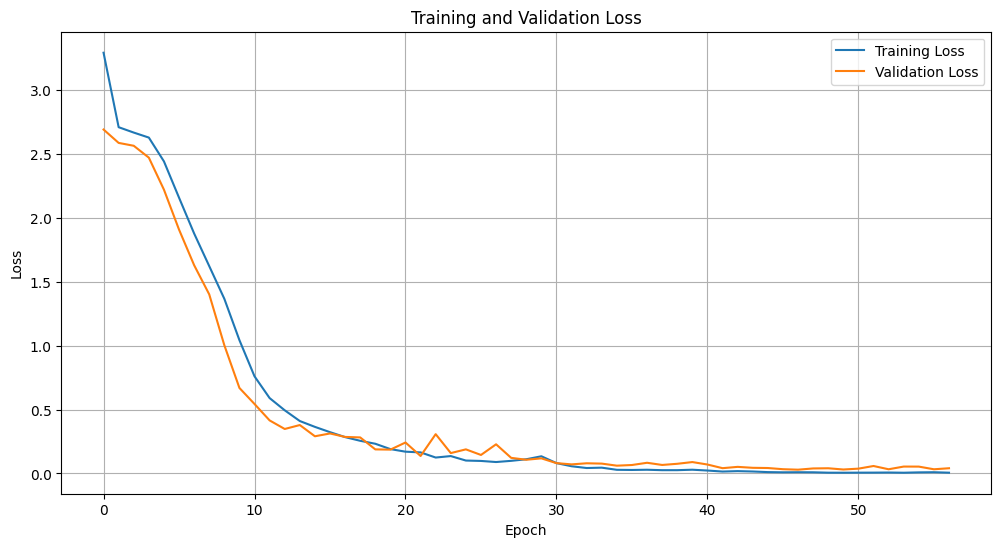

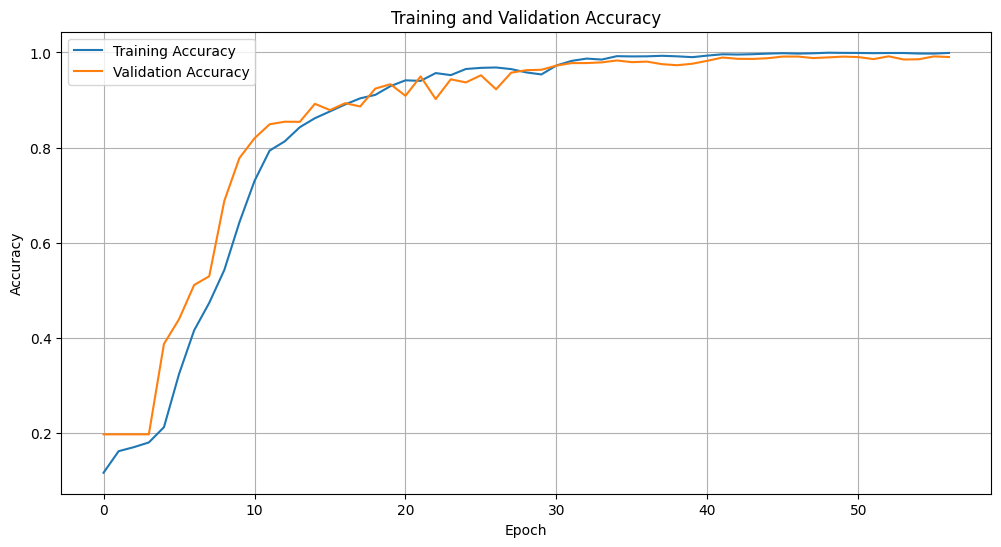

In [32]:
print("\n--- Building Full Transformer Model ---")
# Increased num_layers to 4 and reduced dropout to 0.2
# Assuming seq_length is 256
transformer_model = transformer(
    num_layers=num_layers,
    num_heads=num_heads,
    text_seq_length=seq_length,
    label_seq_length=seq_length - 1,
    embed_dim=embed_dim,
    ff_dim=ff_dim,
    vocab_text=vocab_text,
    vocab_label=vocab_label,
    dropout=dropout,
    name='my_transformer_model'
)
# Compiling the model
# Using a fixed AdamW learning rate for faster convergence on a small dataset
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
# Alternative using the custom schedule:
# learning_rate = CustomSchedule(d_model=embed_dim)
# optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4)
transformer_model.compile(loss=masked_loss, optimizer=optimizer, metrics=[mask_accuracy])

# Increased EarlyStopping patience to 10
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), ModelCheckpoint('best_model.h5', save_best_only=True)]

print(f"Starting training for 200 epochs (with EarlyStopping up to {callbacks[0].patience} epochs patience).")
try:
    history = transformer_model.fit(train_ds, validation_data=test_ds, epochs=200, callbacks=callbacks)
    print("\nTraining complete!")

    # Evaluation and plotting code
    print("\n--- Evaluating Model ---")
    loss, accuracy = transformer_model.evaluate(test_ds)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mask_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_mask_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_plot.png')

    print("\n--- Predicting and Comparing with Test Data ---")
    label_vocab = loaded_label_vec.get_vocabulary()
    index_to_label = {index: token for index, token in enumerate(label_vocab)}
    text_vocab = loaded_text_vec.get_vocabulary()
    index_to_text = {index: token for index, token in enumerate(text_vocab)}

    def tokens_to_text(token_ids, vocab_map):
        tokens = [vocab_map.get(token_id, '[UNK]') for token_id in token_ids if token_id != 0]
        filtered_tokens = [token for token in tokens if token not in ['[start]', '[end]']]
        return ' '.join(filtered_tokens)

    # Placeholder for ROUGE score calculation
    def calculate_rouge_scores(references, candidates):
        """
        Placeholder function for calculating ROUGE scores.
        You would replace this with actual logic using a library like rouge-score.
        Example:
        from rouge_score import rouge_scorer
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        scores = [scorer.score(ref, cand) for ref, cand in zip(references, candidates)]
        return scores
        """
        print("\nNote: ROUGE score calculation is a placeholder. Install and use 'rouge-score' library for actual metrics.")
        return {'rouge-1': 'N/A', 'rouge-2': 'N/A', 'rouge-L': 'N/A'}

    all_actuals, all_predictions = [], []
    for batch_source, batch_target in test_ds.take(1):
        # The key change is here: using the autoregressive function
        predicted_token_ids = generate_labels_autoregressive(
            transformer_model,
            batch_source['encode_inp'],  # Pass the encoder input
            start_token=start_token,
            end_token=end_token,
            max_len=max_seq_len,
            p=0.9
        )

        for i in range(predicted_token_ids.shape[0]):
            input_text = tokens_to_text(batch_source['encode_inp'][i].numpy(), index_to_text)
            predicted_text = tokens_to_text(predicted_token_ids[i], index_to_label)
            actual_text = tokens_to_text(batch_target[i].numpy(), index_to_label)

            all_actuals.append(actual_text)
            all_predictions.append(predicted_text)

            print(f"Input Text: {input_text}")
            print(f"Predicted Label: {predicted_text}")
            print(f"Actual Label: {actual_text}")
            print("-" * 20)

    # Calculate ROUGE scores on the batch predictions
    # This is a placeholder call. Replace with real implementation.
    rouge_scores = calculate_rouge_scores(all_actuals, all_predictions)
    print("ROUGE Scores (on a single test batch):", rouge_scores)

except Exception as e:
    print(f"\nAn error occurred during training: {e}")
    print("Please check your data paths, NLTK downloads, and the error traceback for more details.")

In [68]:
transformer_model.save("pulp_transformer_model.keras", include_optimizer=False)
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [71]:
!zip -r pulp_transformer_model.zip pulp_transformer_model.h5

  adding: pulp_transformer_model.h5 (deflated 8%)


In [72]:
from google.colab import files
files.download("pulp_transformer_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
def beam_search_decode(model, text_input, start_token, end_token, max_len, beam_width=5):
    """
    Generates a sequence of labels using Beam Search.
    """
    batch_size = tf.shape(text_input)[0]
    vocab_size = loaded_label_vec.vocabulary_size()
    padding_token = 0

    # Initialize beams: (sequence, log_probability)
    # Start with the start token for each sequence in the batch
    # Beams shape: [batch_size * beam_width, seq_len]
    beams = tf.fill(dims=(batch_size * beam_width, 1), value=start_token)
    # Initialize log probabilities (higher is better for log probs)
    log_probs = tf.zeros(batch_size * beam_width, dtype=tf.float32)
    # Initialize for the first step: repeat the input text beam_width times
    text_input_repeated = tf.repeat(text_input, repeats=beam_width, axis=0)


    for i in range(max_len):
        current_seq_len = tf.shape(beams)[1]
        padding_needed = max_len - 1 - current_seq_len
        padding_shape = [[0, 0], [0, padding_needed]]
        padded_decoder_input = tf.pad(beams, padding_shape, "CONSTANT", constant_values=padding_token)

        # Get predictions for the next token for all current beams
        predictions = model({'encode_inp': text_input_repeated, 'decode_inp': padded_decoder_input[:, :max_len-1]})
        last_token_position = current_seq_len - 1
        last_token_logits = predictions[:, last_token_position, :] # Shape: [batch_size * beam_width, vocab_size]

        # Get log probabilities (log_softmax for numerical stability)
        log_probabilities = tf.nn.log_softmax(last_token_logits, axis=-1) # Shape: [batch_size * beam_width, vocab_size]

        # Calculate cumulative log probabilities for each possible next token
        # current_log_probs + log_prob_of_next_token
        # Reshape log_probs to [batch_size * beam_width, 1] for broadcasting
        cumulative_log_probabilities = tf.expand_dims(log_probs, 1) + log_probabilities # Shape: [batch_size * beam_width, vocab_size]


        # Reshape cumulative_log_probabilities to [batch_size, beam_width * vocab_size]
        reshaped_log_probs = tf.reshape(cumulative_log_probabilities, [batch_size, beam_width * vocab_size])

        # Get top beam_width candidates across all expanded beams for each sequence in the batch
        top_k_log_probs, top_k_indices = tf.math.top_k(reshaped_log_probs, k=beam_width) # Shape: [batch_size, beam_width]

        # Convert indices back to original beam index and token index
        original_beam_indices = top_k_indices // vocab_size # Shape: [batch_size, beam_width]
        next_token_indices = top_k_indices % vocab_size # Shape: [batch_size, beam_width]

        # Gather the sequences from the original beams based on the selected indices
        # Need to reshape original beams to [batch_size, beam_width, seq_len] to use tf.gather
        beams_reshaped = tf.reshape(beams, [batch_size, beam_width, current_seq_len])
        # Gather the selected beams
        selected_beams = tf.gather(beams_reshaped, original_beam_indices, batch_dims=1) # Shape: [batch_size, beam_width, current_seq_len]

        # Concatenate the selected beams with the predicted next tokens
        # Reshape next_token_indices to [batch_size, beam_width, 1] for concatenation
        next_tokens_expanded = tf.expand_dims(next_token_indices, -1)
        new_beams = tf.concat([selected_beams, tf.cast(next_tokens_expanded, dtype=tf.int64)], axis=-1) # Shape: [batch_size, beam_width, current_seq_len + 1]

        # Flatten new_beams and top_k_log_probs for the next iteration
        beams = tf.reshape(new_beams, [batch_size * beam_width, current_seq_len + 1])
        log_probs = tf.reshape(top_k_log_probs, [batch_size * beam_width])

        # Check if all beams in the batch have generated the end token
        # This check needs to be done per sequence in the batch
        if tf.reduce_all(tf.equal(next_token_indices, end_token)):
            break

    # After the loop, the 'beams' tensor contains the top 'beam_width' sequences for each
    # sequence in the original batch. We need to select the best one for each batch item.
    # Find the index of the beam with the highest log probability for each sequence in the batch
    log_probs_reshaped = tf.reshape(log_probs, [batch_size, beam_width])
    best_beam_indices = tf.argmax(log_probs_reshaped, axis=-1) # Shape: [batch_size]

    # Gather the best beam for each sequence in the batch
    final_outputs = tf.gather(tf.reshape(beams, [batch_size, beam_width, tf.shape(beams)[1]]), best_beam_indices, batch_dims=1) # Shape: [batch_size, seq_len]


    return final_outputs

In [34]:
# Example usage of beam search decoding

# Assuming transformer_model, loaded_text_vec, loaded_label_vec,
# start_token, end_token, and max_seq_len are available from previous cells.
# IMPORTANT: Ensure the cell defining start_token, end_token, and max_seq_len (e.g., cell m8yOo1Ys86jV) has been executed before this cell.

# Get special token IDs from the vocabulary and the max sequence length
label_vocab = loaded_label_vec.get_vocabulary()
start_token = loaded_label_vec('[start]')[0].numpy()
end_token = loaded_label_vec('[end]')[0].numpy()
max_seq_len = loaded_label_vec.get_config()['output_sequence_length']


# Get a sample input text from the test dataset
sample_text = train_pairs[0][0] # Or get a sample from test_pairs

# Convert the sample text to input tensor
sample_text_input = loaded_text_vec([sample_text]) # Add batch dimension

# Perform beam search decoding
predicted_token_ids_beam_search = beam_search_decode(
    transformer_model,
    sample_text_input,
    start_token=start_token,
    end_token=end_token,
    max_len=max_seq_len,
    beam_width=5 # You can adjust the beam width
)

# Convert the predicted token IDs back to human-readable text
label_vocab = loaded_label_vec.get_vocabulary()
index_to_label = {index: token for index, token in enumerate(label_vocab)}

def tokens_to_text(token_ids, vocab_map):
    tokens = [vocab_map.get(token_id, '[UNK]') for token_id in token_ids if token_id != 0]
    filtered_tokens = [token for token in tokens if token not in ['[start]', '[end]']]
    return ' '.join(filtered_tokens)

predicted_label_beam_search = tokens_to_text(predicted_token_ids_beam_search[0].numpy(), index_to_label)

print(f"Original Text: {sample_text}")
print(f"Predicted Label (Beam Search): {predicted_label_beam_search}")

Original Text: mush container fuse junction method acting make mould mush container fuse junction method acting make allow for present invention allow for mush container be mould mush consistence wherein consistence be bottom to the lowest degree one slope palisade word form enclosed space wherein to the lowest degree one slope palisade be amphetamine lip neck opening wherein neck opening be amphetamine closure divide humiliated lip fuse junction wherein divide amphetamine lip to the lowest degree one sidewall consistence divide humiliated lip neck opening array fuse together fuse junction may word form supersonic dyer's mignonette ace method acting fabricate mush container method acting be generate offset divide beat wherein offset divide beat be offset lip generate indorse divide beat wherein indorse divide beat be indorse lip laminate Department of the Interior surface to the lowest degree one offset indorse divide beat polymer flick run offset indorse lip array offset indorse divid

In [35]:
# --- Assuming the following functions and objects are defined in previous cells ---
# def beam_search_decode(...): ...
# loaded_text_vec = TextVectorization(...)
# loaded_label_vec = TextVectorization(...)
# transformer_model = tf.keras.Model(...)
# df_combined = pd.DataFrame(...) # The DataFrame with the original combined text
# index_to_label, tokens_to_text functions are defined
# normalize function is defined
# IMPORTANT: Ensure df_combined is populated by running cell _K2EPF1m662O before this cell.
# IMPORTANT: Ensure start_token, end_token, and max_seq_len are populated by running cell m8yOo1Ys86jV before this cell.
# --------------------------------------------------------------------------------

print("\n--- Performing Beam Search Decoding on the Entire Dataset ---")

# 1. Prepare the data for beam search generation
texts_to_predict = combine['combined'].tolist()

# Assuming the normalize function is defined in a previous cell
normalized_texts = [normalize(text, "")[0] for text in texts_to_predict]

# 2. Format the new dataset for prediction (batch size 1 for current beam search implementation)
# Recreate the dataset with batch size 1 for compatibility with the current beam_search_decode function
# Use from_tensor_slices with normalized_texts
predict_ds_gen_beam = tf.data.Dataset.from_tensor_slices((normalized_texts)).batch(1)

# Map the dataset to format the text for the model input
def format_dataset_for_beam_generation(text):
    text_vec = loaded_text_vec(text)
    return text_vec

predict_ds_gen_beam = predict_ds_gen_beam.map(format_dataset_for_beam_generation)


# 3. Generate labels using the trained transformer model (beam search)
all_predicted_token_ids_beam = []
print("Starting beam search decoding for all samples...")
for i, batch_text_input in enumerate(predict_ds_gen_beam):
    if i % 10 == 0:
        print(f"Processing sample batch {i}...")
    try:
        batch_predictions_beam = beam_search_decode(
            transformer_model,
            batch_text_input,
            start_token=start_token,
            end_token=end_token,
            max_len=max_seq_len,
            beam_width=5 # You can adjust the beam width
        )
        all_predicted_token_ids_beam.extend(batch_predictions_beam.numpy())
    except Exception as e:
        print(f"Error processing sample batch {i} with beam search: {e}")
        # Append a placeholder or skip this sample if an error occurs
        # Assuming end_token is a valid placeholder for an error
        all_predicted_token_ids_beam.append(np.array([start_token, end_token])) # Placeholder for error


print("Beam search decoding complete.")

# 4. Convert predicted token IDs to human-readable labels
# Assuming loaded_label_vec and index_to_label from previous cells are available
label_vocab = loaded_label_vec.get_vocabulary()
index_to_label = {index: token for index, token in enumerate(label_vocab)}

# Assuming tokens_to_text function is defined in a previous cell
def tokens_to_text(token_ids, vocab_map):
    tokens = [vocab_map.get(token_id, '[UNK]') for token_id in token_ids if token_id != 0]
    filtered_tokens = [token for token in tokens if token not in ['[start]', '[end]']]
    return ' '.join(filtered_tokens)

predicted_labels_human_readable_beam = []
# Ensure the number of predicted token IDs matches the number of original texts
num_samples = len(texts_to_predict)
for token_ids in all_predicted_token_ids_beam[:num_samples]:
    predicted_labels_human_readable_beam.append(tokens_to_text(token_ids, index_to_label))


# 5. Create a new DataFrame with the original text, predicted labels, and actual labels
# Assuming df_combined is available and contains 'combined' and 'Unnamed: 0' columns
output_df_beam = pd.DataFrame({
    'Original Text': combine['combined'],
    'Predicted Label (Beam Search)': predicted_labels_human_readable_beam,
    'Actual Label': combine['Unnamed: 0'] # Assuming 'Unnamed: 0' is the actual label column
})

# 6. Save the DataFrame to an Excel file
output_file_path_beam = 'predictions_output_beam_search.xlsx'
output_df_beam.to_excel(output_file_path_beam, index=False)

print(f"\nBeam search prediction results saved to '{output_file_path_beam}'")

# 7. Display the first few predictions
print("\nFirst 10 human-readable predicted labels (Beam Search):")
for i, label in enumerate(predicted_labels_human_readable_beam[:10]):
    print(f"Sample {i+1}: {label}")


--- Performing Beam Search Decoding on the Entire Dataset ---
Starting beam search decoding for all samples...
Processing sample batch 0...
Processing sample batch 10...
Processing sample batch 20...
Processing sample batch 30...
Processing sample batch 40...
Processing sample batch 50...
Processing sample batch 60...
Processing sample batch 70...
Processing sample batch 80...
Processing sample batch 90...
Processing sample batch 100...
Beam search decoding complete.

Beam search prediction results saved to 'predictions_output_beam_search.xlsx'

First 10 human-readable predicted labels (Beam Search):
Sample 1: Equipment for manufacturing and Method of Manufacturing
Sample 2: Structure of the product ,Material of product/ barrier and Method of Manufacturing
Sample 3: Method of Manufacturing and Structure of the product
Sample 4: Method of Manufacturing
Sample 5: Method of Manufacturing and Structure of the product
Sample 6: Material of product/ barrier and Structure of the product
Samp

In [36]:
import tensorflow as tf
import numpy as np

# Assuming you have your trained model and the TextVectorization layer loaded
def predict_with_repetition_penalty(model, text_vectorization_layer, input_text, max_length=256, penalty=1.2):
    """
    Generates text with a repetition penalty.

    Args:
        model: Your trained Keras model.
        text_vectorization_layer: The text vectorization layer from your notebook.
        input_text: The starting text for the prediction.
        max_length: The maximum length of the generated sequence.
        penalty: A float value to penalize repeated words. A value > 1.0 penalizes repetitions.
    """
    input_tokens = text_vectorization_layer([input_text])
    output_tokens = input_tokens

    for _ in range(max_length - 1):
        # Get the model's predictions
        predictions = model.predict(output_tokens)

        # Get the logits (pre-softmax output)
        logits = predictions[0, -1, :]

        # Apply the repetition penalty
        unique_tokens = np.unique(output_tokens[0].numpy())
        for token_id in unique_tokens:
            if token_id != 0:  # Don't penalize padding token
                logits[token_id] /= penalty

        # Select the next token
        next_token = tf.argmax(logits, axis=-1)
        next_token = tf.expand_dims([next_token], 0)

        # Append the new token to the output sequence
        output_tokens = tf.concat([output_tokens, next_token], axis=-1)

        # Stop if an end-of-sequence token is predicted (if you have one)
        # if next_token.numpy()[0][0] == end_of_sequence_id:
        #     break

    # Convert token IDs back to text
    return text_vectorization_layer.get_vocabulary()[output_tokens[0].numpy()]

# Example usage:
# Assuming 'your_model' and 'text_vectorization' are already defined
# prediction_result = predict_with_repetition_penalty(your_model, text_vectorization, "Some starting phrase.")
# print(prediction_result)

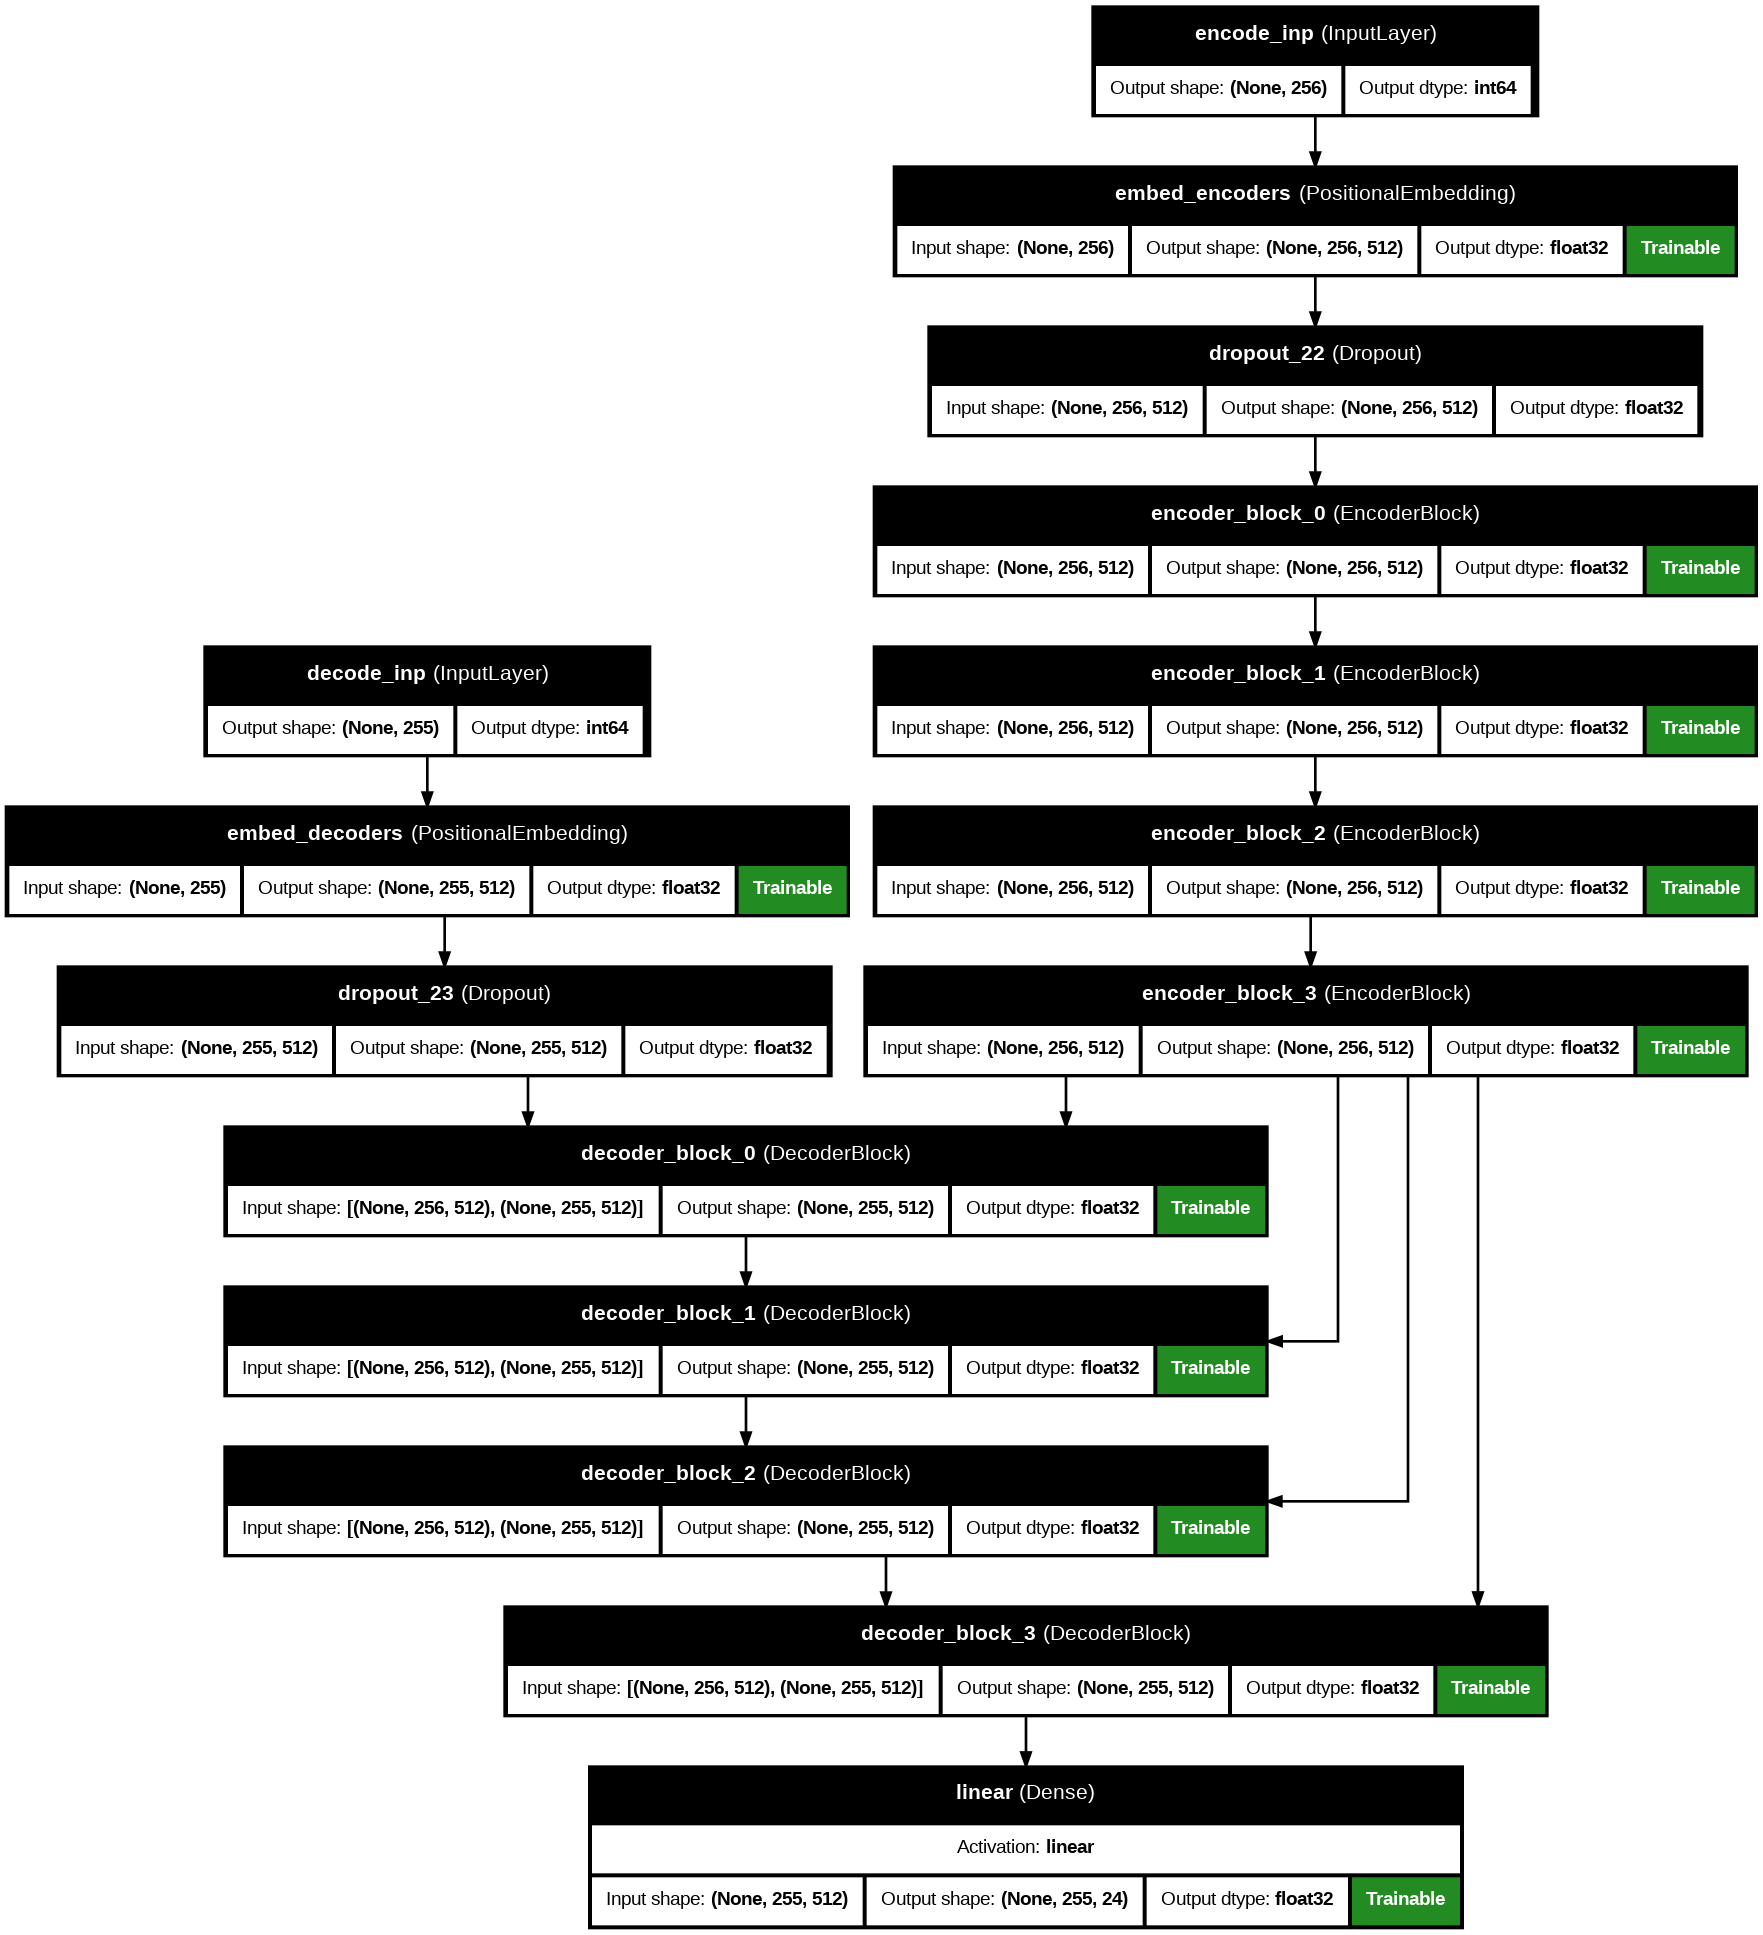

In [37]:
tf.keras.utils.plot_model(
    transformer_model,
    to_file="transformer_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    show_layer_activations=True,
    show_trainable=True,
)

In [38]:
print("\n--- Evaluating Model ---")
loss, accuracy = transformer_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


--- Evaluating Model ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - loss: 0.0296 - mask_accuracy: 0.9915
Test Loss: 0.0294
Test Accuracy: 0.9915


In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a trained model, test data (test_text), and true labels (test_labels)
# The output of your model will be a set of predicted labels
# You'll need to run your model on the test data to get predictions
# e.g., predictions = model.predict(test_text)

# If your model's output is one-hot encoded, convert it to class indices
# predicted_classes = np.argmax(predictions, axis=1)

# Generate a classification report
print("Classification Report:")

# Use the variables populated in the previous cell (442mw3ijNsiM)
try:
    # Ensure label_names is also available from cell 442mw3ijNsiM
    if 'all_actual_labels' in locals() and 'all_predicted_labels' in locals() and 'label_names' in locals():
         print(classification_report(all_actual_labels, all_predicted_labels, target_names=label_names, zero_division=0))
    else:
        print("Required variables (all_actual_labels, all_predicted_labels, label_names) not found. Please run the preceding cells.")
except NameError as e:
    print(f"Error generating classification report: {e}. Make sure cell 442mw3ijNsiM has been run.")


# Generate and print the confusion matrix
print("\nConfusion Matrix:")
# The confusion matrix is already calculated and plotted in cell 442mw3ijNsiM
# You can uncomment the lines below if you want to print it here again
# cm = confusion_matrix(all_actual_labels, all_predicted_labels)
# print(cm)

# The confusion matrix visualization is already done in cell 442mw3ijNsiM
# You can uncomment the lines below if you want to plot it here again
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()

Classification Report:
Required variables (all_actual_labels, all_predicted_labels, label_names) not found. Please run the preceding cells.

Confusion Matrix:



--- Generating Confusion Matrix ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


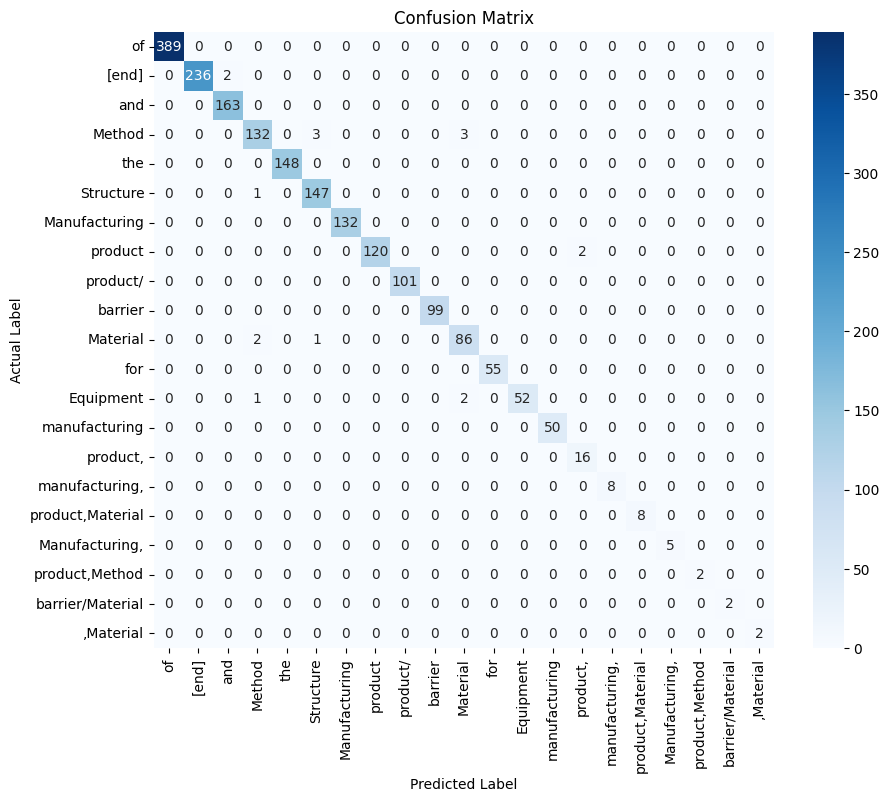

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Generating Confusion Matrix ---")

# Get actual and predicted labels for the test dataset
all_actual_labels = []
all_predicted_labels = []

for batch_source, batch_target in test_ds:
    batch_predictions = transformer_model.predict(batch_source)
    predicted_token_ids = tf.argmax(batch_predictions, axis=-1).numpy()
    actual_token_ids = batch_target.numpy()

    # Flatten the arrays and remove padding (token 0)
    predicted_flat = predicted_token_ids.flatten()
    actual_flat = actual_token_ids.flatten()

    # Filter out padding tokens
    non_padding_indices = actual_flat != 0
    actual_filtered = actual_flat[non_padding_indices]
    predicted_filtered = predicted_flat[non_padding_indices]

    all_actual_labels.extend(actual_filtered)
    all_predicted_labels.extend(predicted_filtered)

# Convert lists to numpy arrays
all_actual_labels = np.array(all_actual_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(all_actual_labels, all_predicted_labels)

# Get the unique labels present in the actual and predicted data
unique_labels = np.unique(np.concatenate((all_actual_labels, all_predicted_labels)))

# Get the corresponding label names from the vocabulary
label_vocab = loaded_label_vec.get_vocabulary()
label_names = [label_vocab[i] for i in unique_labels]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [41]:
print("\n--- Predicting and Comparing with Test Data ---")
label_vocab = loaded_label_vec.get_vocabulary()
index_to_label = {index: token for index, token in enumerate(label_vocab)}
text_vocab = loaded_text_vec.get_vocabulary()
index_to_text = {index: token for index, token in enumerate(text_vocab)}

def tokens_to_text(token_ids, vocab_map):
    tokens = [vocab_map.get(token_id, '[UNK]') for token_id in token_ids if token_id != 0]
    filtered_tokens = [token for token in tokens if token not in ['[start]', '[end]']]
    return ' '.join(filtered_tokens)

# Use the already trained model from the previous cell
if 'transformer_model' in locals():
    for batch_source, batch_target in test_ds.take(1): # Take a small batch for demonstration
        batch_predictions = transformer_model.predict(batch_source)
        predicted_token_ids = tf.argmax(batch_predictions, axis=-1).numpy()
        for i in range(predicted_token_ids.shape[0]):
            input_text = tokens_to_text(batch_source['encode_inp'][i].numpy(), index_to_text)
            predicted_text = tokens_to_text(predicted_token_ids[i], index_to_label)
            actual_text = tokens_to_text(batch_target[i].numpy(), index_to_label)
            print(f"Input Text: {input_text}")
            print(f"Predicted Label: {predicted_text}")
            print(f"Actual Label: {actual_text}")
            print("-" * 20)
else:
    print("Model 'transformer_model' not found. Please train the model first.")


--- Predicting and Comparing with Test Data ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Input Text: o body of water vapour roadblock pic low moisture sensitivity fabricate selfcrosslinking fibrillate cellulose provide box textile contain o roadblock polymer pic wherein pic comprises polymer obtainable summons contain whole tone oxidize cellulose character finally get crosslinked cellulose bcomplex vitamin homogenize ware whole tone get fibril breadth swan ane nanometre 150 nanometre correspond practice also provide ane box textile contain o roadblock polymer pic wherein pic comprises polymer obtainable summons contain whole tone oxidize cellulose character dialdehyde cellulose finally get crosslinked cellulose bcomplex vitamin homogenize ware whole tone get fibril breadth swan ane nanometre 150 nanometre two box textile contain o roadblock polymer pic wherein pic comprises polymer obtainable summons contain whole tone oxidize cellulose character dialdehyde cellulose stage 2050 finally 

In [42]:
print("\n--- Predicting and Comparing with Test Data ---")
label_vocab = loaded_label_vec.get_vocabulary()
index_to_label = {index: token for index, token in enumerate(label_vocab)}
text_vocab = loaded_text_vec.get_vocabulary()
index_to_text = {index: token for index, token in enumerate(text_vocab)}

def tokens_to_text(token_ids, vocab_map):
    tokens = [vocab_map.get(token_id, '[UNK]') for token_id in token_ids if token_id != 0]
    filtered_tokens = [token for token in tokens if token not in ['[start]', '[end]']]
    return ' '.join(filtered_tokens)

# Use the already trained model from the previous cell
if 'transformer_model' in locals():
    for batch_source, batch_target in test_ds.take(1): # Take a small batch for demonstration
        batch_predictions = transformer_model.predict(batch_source)
        predicted_token_ids = tf.argmax(batch_predictions, axis=-1).numpy()
        for i in range(predicted_token_ids.shape[0]):
            input_text = tokens_to_text(batch_source['encode_inp'][i].numpy(), index_to_text)
            predicted_text = tokens_to_text(predicted_token_ids[i], index_to_label)
            actual_text = tokens_to_text(batch_target[i].numpy(), index_to_label)
            print(f"Input Text: {input_text}")
            print(f"Predicted Label: {predicted_text}")
            print(f"Actual Label: {actual_text}")
            print("-" * 20)
else:
    print("Model 'transformer_model' not found. Please train the model first.")


--- Predicting and Comparing with Test Data ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Input Text: o body of water vapour roadblock pic low moisture sensitivity fabricate selfcrosslinking fibrillate cellulose provide box textile contain o roadblock polymer pic wherein pic comprises polymer obtainable summons contain whole tone oxidize cellulose character finally get crosslinked cellulose bcomplex vitamin homogenize ware whole tone get fibril breadth swan ane nanometre 150 nanometre correspond practice also provide ane box textile contain o roadblock polymer pic wherein pic comprises polymer obtainable summons contain whole tone oxidize cellulose character dialdehyde cellulose finally get crosslinked cellulose bcomplex vitamin homogenize ware whole tone get fibril breadth swan ane nanometre 150 nanometre two box textile contain o roadblock polymer pic wherein pic comprises polymer obtainable summons contain whole tone oxidize cellulose character dialdehyde cellulose stage 2050 finally g

# Predicting Entire Dataset

In [43]:
df_combined = pd.read_excel('combined_data.xlsx')


In [44]:
# --- Assuming the following functions and objects are defined in previous cells ---
# def normalize(text, label): ...
# loaded_text_vec = TextVectorization(...)
# loaded_label_vec = TextVectorization(...)
# transformer_model = tf.keras.Model(...)
# IMPORTANT: Run this cell before cell m8yOo1Ys86jV to populate normalized_texts.
# --------------------------------------------------------------------------------

# 1. Prepare the data for autoregressive generation
texts_to_predict = df_combined['combined'].tolist()
normalized_texts = [normalize(text, "")[0] for text in texts_to_predict]

In [45]:
def generate_labels_autoregressive(model, text_input, start_token, end_token, max_len, p=0.9):
    """
    Generates a sequence of labels autoregressively using Top-p (Nucleus) sampling.
    Pads the decoder input to max_len - 1 for compatibility with the model's expected input shape.
    """
    batch_size = tf.shape(text_input)[0]
    # Get the vocabulary size from the loaded_label_vec layer
    vocab_size = loaded_label_vec.vocabulary_size()
    # Get the padding token ID (assuming it's 0 due to mask_zero=True)
    padding_token = 0

    # Initialize the decoder input with the start token for each sequence in the batch
    decoder_input = tf.fill(dims=(batch_size, 1), value=start_token)

    # Loop to generate tokens one by one up to max_len
    for i in range(max_len): # Iterate up to max_len to generate sequences up to max_len tokens long
        # Pad the current decoder_input to the expected sequence length for the model
        current_seq_len = tf.shape(decoder_input)[1]
        padding_needed = max_len - 1 - current_seq_len # Model expects max_len - 1 input tokens
        if padding_needed < 0: # Should not happen with proper max_len
             padding_needed = 0
        padding_shape = [[0, 0], [0, padding_needed]]
        padded_decoder_input = tf.pad(decoder_input, padding_shape, "CONSTANT", constant_values=padding_token)

        # Pass the encoded text and the padded generated sequence to the model
        # Only pass the first max_len - 1 tokens of the padded input to match the model's expected shape
        predictions = model({'encode_inp': text_input, 'decode_inp': padded_decoder_input[:, :max_len-1]})


        # Get the logits for the next token (which corresponds to the last non-padded token position)
        # The index should be the position after the last generated token
        last_token_position = current_seq_len - 1
        last_token_logits = predictions[:, last_token_position, :]


        # Reshape logits to 2D for Top-p sampling
        logits_2d = tf.reshape(last_token_logits, [-1, vocab_size])

        # Apply Top-p (Nucleus) sampling
        sorted_logits = tf.sort(logits_2d, axis=-1, direction='DESCENDING')
        sorted_indices = tf.argsort(logits_2d, axis=-1, direction='DESCENDING')
        cumulative_probs = tf.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

        # Create a mask to filter tokens based on cumulative probability p
        indices_to_remove = cumulative_probs > p
        # Ensure that the first token (most likely) is never removed
        indices_to_remove = tf.concat([
            tf.zeros([tf.shape(indices_to_remove)[0], 1], dtype=tf.bool),
            indices_to_remove[:, :-1]
        ], axis=-1)
        # Mask the logits
        masked_logits = tf.where(indices_to_remove, -1e9, sorted_logits)

        # Sample a single token from the filtered distribution
        sampled_indices_in_sorted_order = tf.random.categorical(masked_logits, num_samples=1)
        # Get the actual token IDs from the original vocabulary indices
        next_tokens = tf.gather(sorted_indices, sampled_indices_in_sorted_order, batch_dims=1)


        # Concatenate the new token to the generated sequence
        decoder_input = tf.concat([decoder_input, tf.cast(next_tokens, dtype=tf.int64)], axis=1)

        # Stop if all sequences in the batch have generated the end token
        # We check the newly generated token
        if tf.reduce_all(tf.equal(next_tokens, end_token)):
            break

    return decoder_input

In [46]:
# IMPORTANT: Ensure normalized_texts is populated by running cell CVOpdM-F8zAR before this cell.
predict_ds_gen = tf.data.Dataset.from_tensor_slices(normalized_texts)
predict_ds_gen = predict_ds_gen.map(lambda x: loaded_text_vec(x))
predict_ds_gen = predict_ds_gen.batch(64).prefetch(tf.data.AUTOTUNE).cache()


# Get special token IDs from the vocabulary
label_vocab = loaded_label_vec.get_vocabulary()
start_token = loaded_label_vec('[start]')[0].numpy()
end_token = loaded_label_vec('[end]')[0].numpy()
max_seq_len = loaded_label_vec.get_config()['output_sequence_length']

In [47]:
all_predicted_token_ids = []
for batch_text_input in predict_ds_gen:
    batch_predictions = generate_labels_autoregressive(
        transformer_model,
        batch_text_input,
        start_token=start_token,
        end_token=end_token,
        max_len=max_seq_len,
        p=0.9
    )
    all_predicted_token_ids.extend(batch_predictions.numpy())

# 4. Convert predicted token IDs to human-readable labels
index_to_label = {index: token for index, token in enumerate(label_vocab)}
predicted_labels_human_readable = []
for token_ids in all_predicted_token_ids:
    tokens = [index_to_label.get(token_id, '[UNK]') for token_id in token_ids if token_id != 0]
    filtered_tokens = [token for token in tokens if token not in ['[start]', '[end]']]
    predicted_labels_human_readable.append(' '.join(filtered_tokens))

# 5. Create a new DataFrame and save it
output_df = pd.DataFrame({
    'Original Text': df_combined['combined'],
    'Predicted Label': predicted_labels_human_readable,
    'Actual Label': df_combined['Unnamed: 0']
})
output_df.to_excel('predictions_output_new.xlsx', index=False)

print("Prediction results saved to 'predictions_output_new.xlsx'")
print("First 10 human-readable predicted labels:")
for i, label in enumerate(predicted_labels_human_readable[:10]):
    print(f"Sample {i+1}: {label}")

Prediction results saved to 'predictions_output_new.xlsx'
First 10 human-readable predicted labels:
Sample 1: Equipment for manufacturing and Method of Manufacturing
Sample 2: Structure of the product ,Material of product/ barrier and Method of Manufacturing
Sample 3: Method of Manufacturing and Structure of the product
Sample 4: Method of Manufacturing of Manufacturing product
Sample 5: Method of Manufacturing and Structure of the product
Sample 6: Material of product/ barrier and Structure of the product barrier
Sample 7: Structure of the product of product/ barrier and Method of Manufacturing
Sample 8: Structure of the product of product/ barrier
Sample 9: Material of product/ barrier and Method of Manufacturing
Sample 10: Structure of the product and Material of product/ barrier


In [48]:
# Assuming the list 'all_predicted_token_ids' is populated from your previous code.
# Also assuming 'df_combined' and 'loaded_label_vec' are available from earlier in your notebook.

# 1. Convert predicted token IDs to human-readable labels
# Retrieve the label vocabulary
label_vocab = loaded_label_vec.get_vocabulary()

# Create a mapping from token IDs to labels
index_to_label = {index: token for index, token in enumerate(label_vocab)}

# Function to convert token IDs to text
def tokens_to_text(token_ids, vocab_map):
    tokens = [vocab_map.get(token_id, '[UNK]') for token_id in token_ids if token_id != 0]
    filtered_tokens = [token for token in tokens if token not in ['[start]', '[end]']]
    return ' '.join(filtered_tokens)

predicted_labels_human_readable = []
for token_ids in all_predicted_token_ids:
    predicted_labels_human_readable.append(tokens_to_text(token_ids, index_to_label))

# 2. Create a new DataFrame with the original text, predicted labels, and actual labels
output_df = pd.DataFrame({
    'Original Text': df_combined['combined'],
    'Predicted Label': predicted_labels_human_readable,
    'Actual Label': df_combined['Unnamed: 0']
})

# 3. Save the DataFrame to a new Excel file
output_df.to_excel('predictions_output_final.xlsx', index=False)

print("Prediction results have been saved to 'predictions_output_final.xlsx'")
print("\nFirst 10 human-readable predicted labels:")
for i, label in enumerate(predicted_labels_human_readable[:10]):
    print(f"Sample {i+1}: {label}")

Prediction results have been saved to 'predictions_output_final.xlsx'

First 10 human-readable predicted labels:
Sample 1: Equipment for manufacturing and Method of Manufacturing
Sample 2: Structure of the product ,Material of product/ barrier and Method of Manufacturing
Sample 3: Method of Manufacturing and Structure of the product
Sample 4: Method of Manufacturing of Manufacturing product
Sample 5: Method of Manufacturing and Structure of the product
Sample 6: Material of product/ barrier and Structure of the product barrier
Sample 7: Structure of the product of product/ barrier and Method of Manufacturing
Sample 8: Structure of the product of product/ barrier
Sample 9: Material of product/ barrier and Method of Manufacturing
Sample 10: Structure of the product and Material of product/ barrier


**Reasoning**:
Create a new DataFrame with the original text, predicted labels, and actual labels, and save it to an Excel file.



In [ ]:
from google.colab import files
files.download('predictions_output_final.xlsx')

# TESTING NEW SET OF PATENTS

In [49]:
df_new = pd.read_excel('New set of patents _Input.xlsx')

In [50]:
df_new.head()

S.No   Record Number                                              Title  \
0   NaN             NaN                                                NaN   
1   NaN             NaN                                                NaN   
2   NaN             NaN                                                NaN   
3   NaN             NaN                                                NaN   
4   1.0  US2023390989A1  METHOD, SYSTEM, AND BLOW MOLDING MACHINE FOR B...   

                                            Abstract  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  A method for blow molding a container having a...   

                                         Full Claims  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  1. A method for blow molding a container havin...   

                                  Independent Claims  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4  1.  1. A method for blow molding a container h...

In [51]:
# Remove the first four rows
df_new = df_new.iloc[4:]

# Remove the first two columns
df_new = df_new.iloc[:, 1:]

# Display the first few rows of the modified DataFrame to verify
display(df_new.head())

Record Number                                              Title  \
4  US2023390989A1  METHOD, SYSTEM, AND BLOW MOLDING MACHINE FOR B...   
5  US2020109515A1                                       Pulp Mixture   
6     EP4452545A1  CUTTING DEVICE AND METHOD FOR MANUFACTURING A ...   
7  WO2024046976A1                 METHOD FOR COATING A DRIED PREFORM   
8  US2023373123A1  CUTTING DEVICE AND FABRICATING TABLE HAVING TH...   

                                            Abstract  \
4  A method for blow molding a container having a...   
5  There is provided a use of a pulp mixture for ...   
6  Disclosed is a cutting device (100) and a meth...   
7  Disclosed is a method for coating a dried pref...   
8  Disclosed is a cutting device (1) for fabricat...   

                                         Full Claims  \
4  1. A method for blow molding a container havin...   
5  1A container that is formed from a pulp mixtur...   
6  1. Cutting device (100) for assembling a fiber...   
7  1. Method for coating a dried blank (61) of a ...   
8  1. A cutting device ( 1) for fabricating a fib...   

                                  Independent Claims  
4  1.  1. A method for blow molding a container h...  
5  1. 1. A container that is formed from a pulp m...  
6  1. patent claimsCutting device (100) for assem...  
7  Patent claims1. Method for coating a dried bla...  
8  1. 1. A cutting device (1) for fabricating a f...

In [52]:
# Save the df_new DataFrame to an Excel file
df_new.to_excel('df_new.xlsx', index=False)

print("df_new DataFrame saved to 'df_new.xlsx'")

df_new DataFrame saved to 'df_new.xlsx'


In [53]:
# Combine all columns into a single 'combined' column, similar to the original data
df_new['combined'] = df_new.astype(str).agg(' '.join, axis=1)

# Create a new DataFrame with only the 'combined' column
df_new_combined = df_new[['combined']].copy()

# Display the first few rows of the modified DataFrame to verify
display(df_new_combined.head())

combined
4  US2023390989A1 METHOD, SYSTEM, AND BLOW MOLDIN...
5  US2020109515A1 Pulp Mixture There is provided ...
6  EP4452545A1 CUTTING DEVICE AND METHOD FOR MANU...
7  WO2024046976A1 METHOD FOR COATING A DRIED PREF...
8  US2023373123A1 CUTTING DEVICE AND FABRICATING ...

In [57]:
all_predicted_token_ids = []
for batch_text_input in predict_ds_gen:
    batch_predictions = generate_labels_autoregressive(
        transformer_model,
        batch_text_input,
        start_token=start_token,
        end_token=end_token,
        max_len=max_seq_len,
        p=0.9
    )
    all_predicted_token_ids.extend(batch_predictions.numpy())

# 4. Convert predicted token IDs to human-readable labels
index_to_label = {index: token for index, token in enumerate(label_vocab)}
predicted_labels_human_readable = []
for token_ids in all_predicted_token_ids:
    tokens = [index_to_label.get(token_id, '[UNK]') for token_id in token_ids if token_id != 0]
    filtered_tokens = [token for token in tokens if token not in ['[start]', '[end]']]
    predicted_labels_human_readable.append(' '.join(filtered_tokens))

# 5. Create a new DataFrame and save it
output_df = pd.DataFrame({
    'Original Text': df_combined['combined'],
    'Predicted Label': predicted_labels_human_readable,
    'Actual Label': df_combined['Unnamed: 0']
})
output_df.to_excel('predictions_output_new.xlsx', index=False)

print("Prediction results saved to 'predictions_output_new.xlsx'")
print("First 10 human-readable predicted labels:")
for i, label in enumerate(predicted_labels_human_readable[:10]):
    print(f"Sample {i+1}: {label}")

Prediction results saved to 'predictions_output_new.xlsx'
First 10 human-readable predicted labels:
Sample 1: Equipment for manufacturing and Method of Manufacturing
Sample 2: Structure of the product ,Material of product/ barrier and Method of Manufacturing
Sample 3: Method of Manufacturing and Structure of the product
Sample 4: Method of Manufacturing of Manufacturing product
Sample 5: Method of Manufacturing and Structure of the product
Sample 6: Material of product/ barrier and Structure of the product barrier
Sample 7: Structure of the product of product/ barrier
Sample 8: Structure of the product of product/ barrier of product/ barrier
Sample 9: Material of product/ barrier and Method of Manufacturing
Sample 10: Structure of the product and Material of product/ barrier


In [58]:
# --- Assuming the following functions and objects are defined in previous cells ---
# def beam_search_decode(...): ...
# loaded_text_vec = TextVectorization(...)
# loaded_label_vec = TextVectorization(...)
# transformer_model = tf.keras.Model(...)
# df_combined = pd.DataFrame(...) # The DataFrame with the original combined text
# index_to_label, tokens_to_text functions are defined
# normalize function is defined
# IMPORTANT: Ensure df_combined is populated by running cell _K2EPF1m662O before this cell.
# IMPORTANT: Ensure start_token, end_token, and max_seq_len are populated by running cell m8yOo1Ys86jV before this cell.
# --------------------------------------------------------------------------------

print("\n--- Performing Beam Search Decoding on the Entire Dataset ---")

# 1. Prepare the data for beam search generation
texts_to_predict = df_new['combined'].tolist()

# Assuming the normalize function is defined in a previous cell
normalized_texts = [normalize(text, "")[0] for text in texts_to_predict]

# 2. Format the new dataset for prediction (batch size 1 for current beam search implementation)
# Recreate the dataset with batch size 1 for compatibility with the current beam_search_decode function
# Use from_tensor_slices with normalized_texts
predict_ds_gen_beam = tf.data.Dataset.from_tensor_slices((normalized_texts)).batch(1)

# Map the dataset to format the text for the model input
def format_dataset_for_beam_generation(text):
    text_vec = loaded_text_vec(text)
    return text_vec

predict_ds_gen_beam = predict_ds_gen_beam.map(format_dataset_for_beam_generation)


# 3. Generate labels using the trained transformer model (beam search)
all_predicted_token_ids_beam = []
print("Starting beam search decoding for all samples...")
for i, batch_text_input in enumerate(predict_ds_gen_beam):
    if i % 10 == 0:
        print(f"Processing sample batch {i}...")
    try:
        batch_predictions_beam = beam_search_decode(
            transformer_model,
            batch_text_input,
            start_token=start_token,
            end_token=end_token,
            max_len=max_seq_len,
            beam_width=5 # You can adjust the beam width
        )
        all_predicted_token_ids_beam.extend(batch_predictions_beam.numpy())
    except Exception as e:
        print(f"Error processing sample batch {i} with beam search: {e}")
        # Append a placeholder or skip this sample if an error occurs
        # Assuming end_token is a valid placeholder for an error
        all_predicted_token_ids_beam.append(np.array([start_token, end_token])) # Placeholder for error


print("Beam search decoding complete.")

# 4. Convert predicted token IDs to human-readable labels
# Assuming loaded_label_vec and index_to_label from previous cells are available
label_vocab = loaded_label_vec.get_vocabulary()
index_to_label = {index: token for index, token in enumerate(label_vocab)}

# Assuming tokens_to_text function is defined in a previous cell
def tokens_to_text(token_ids, vocab_map):
    tokens = [vocab_map.get(token_id, '[UNK]') for token_id in token_ids if token_id != 0]
    filtered_tokens = [token for token in tokens if token not in ['[start]', '[end]']]
    return ' '.join(filtered_tokens)

predicted_labels_human_readable_beam = []
# Ensure the number of predicted token IDs matches the number of original texts
num_samples = len(texts_to_predict)
for token_ids in all_predicted_token_ids_beam[:num_samples]:
    predicted_labels_human_readable_beam.append(tokens_to_text(token_ids, index_to_label))


# 5. Create a new DataFrame with the original text, predicted labels, and actual labels
# Assuming df_combined is available and contains 'combined' and 'Unnamed: 0' columns
output_df_beam = pd.DataFrame({
    'Original Text': df_new['combined'],
    'Predicted Label (Beam Search)': predicted_labels_human_readable_beam
    })

# 6. Save the DataFrame to an Excel file
output_file_path_beam = 'new_set_predictions_output_beam_search.xlsx'
output_df_beam.to_excel(output_file_path_beam, index=False)

print(f"\nBeam search prediction results saved to '{output_file_path_beam}'")

# 7. Display the first few predictions
print("\nFirst 10 human-readable predicted labels (Beam Search):")
for i, label in enumerate(predicted_labels_human_readable_beam[:10]):
    print(f"Sample {i+1}: {label}")


--- Performing Beam Search Decoding on the Entire Dataset ---
Starting beam search decoding for all samples...
Processing sample batch 0...
Processing sample batch 10...
Processing sample batch 20...
Processing sample batch 30...
Processing sample batch 40...
Processing sample batch 50...
Processing sample batch 60...
Processing sample batch 70...
Processing sample batch 80...
Processing sample batch 90...
Processing sample batch 100...
Processing sample batch 110...
Processing sample batch 120...
Processing sample batch 130...
Processing sample batch 140...
Processing sample batch 150...
Beam search decoding complete.

Beam search prediction results saved to 'new_set_predictions_output_beam_search.xlsx'

First 10 human-readable predicted labels (Beam Search):
Sample 1: Method of Manufacturing and Equipment for manufacturing
Sample 2: Material of product/ barrier and Method of Manufacturing
Sample 3: Method of Manufacturing and Equipment for manufacturing
Sample 4: Method of Manufactu

In [59]:
from google.colab import files
files.download('new_set_predictions_output_beam_search.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SUMMARIZATION

In [60]:
import pandas as pd
from transformers import pipeline
import torch

# -------------------------
# Load summarizer
# -------------------------
try:
    device = 0 if torch.cuda.is_available() else -1
    summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=device)
    print(f"Summarizer loaded on {'GPU' if device == 0 else 'CPU'}.")
except Exception as e:
    print(f"Failed to load summarizer on GPU: {e}")
    summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=-1)
    print("Summarizer loaded on CPU fallback.")


# -------------------------
# Summarization function
# -------------------------
def run_patent_summarization(file_path):
    df = pd.read_excel(file_path, header=0)

    # Normalize column names
    df.columns = df.columns.str.strip().str.lower()
    column_map = {
        "publication_number": "publication_number",
        "pub_number": "publication_number",
        "patent_id": "publication_number",
        "title": "title",
        "patent_title": "title",
        "abstract": "abstract",
        "abstract_text": "abstract",
        "claims": "claims",
        "claim_text": "claims"
    }
    df = df.rename(columns={c: column_map.get(c, c) for c in df.columns})

    results = []

    for _, row in df.iterrows():
        title = row.get("title") or ""
        abstract = row.get("abstract") or ""
        claims = row.get("claims") or ""
        pub_num = row.get("publication_number")

        if not (title or abstract or claims):
            print(f"Skipping patent {pub_num} (no text available).")
            continue

        combined_text = f"{title} {abstract} {claims}".strip()
        combined_text = combined_text[:3000]  # prevent token overflow

        # Summarization
        try:
            summary_output = summarizer(combined_text, min_length=50, max_length=250, do_sample=False)
            summary_text = summary_output[0]["summary_text"]
        except Exception as e:
            print(f"Summarization failed for {pub_num}: {e}")
            summary_text = ""

        results.append({
            "publication_number": pub_num,
            "title": title,
            "abstract": abstract,
            "claims": claims,
            "Generated_Summary": summary_text
        })

    # Save results
    output_file_path = "summarized_patents.xlsx"
    pd.DataFrame(results).to_excel(output_file_path, index=False)
    print(f"\nSummarization complete! Results saved to '{output_file_path}'.")


# -------------------------
# Run summarization
# -------------------------
file_path = "df_new.xlsx"
run_patent_summarization(file_path)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0
Your max_length is set to 250, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


Summarizer loaded on GPU.


Your max_length is set to 250, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)
Your max_length is set to 250, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)
Your max_length is set to 250, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 250, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)



Summarization complete! Results saved to 'summarized_patents.xlsx'.


In [61]:
from google.colab import files
files.download('summarized_patents.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
import os
import pandas as pd
from transformers import pipeline
import torch

# -------------------------
# Load summarizer
# -------------------------
try:
    device = 0 if torch.cuda.is_available() else -1
    summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=device)
    print(f"Summarizer loaded on {'GPU' if device == 0 else 'CPU'}.")
except Exception as e:
    print(f"Failed to load summarizer on GPU: {e}")
    summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=-1)
    print("Summarizer loaded on CPU fallback.")


# -------------------------
# Main pipeline
# -------------------------
def run_pipeline_on_file(file_path: str):
    """
    Runs the pipeline on a given Excel file (df_new.xlsx).
    - Combines text from multiple columns
    - Summarizes notes
    - (Hooks for classification, embeddings, vector DB, Google Drive)
    """

    try:
        # Load Excel file
        df = pd.read_excel(file_path)

        # Combine columns (adjust column names if needed)

        results = []

        for i, note in enumerate(df):
            if not isinstance(note, str) or note.strip() == "":
                continue

            # -------------------------
            # Step 1: Classification (placeholder)
            # Replace with your transformer_model.predict(note)
            # For now, assign dummy "AI/ML" to all
            classified_label = "AI/ML"

            if classified_label == "AI/ML":
                # -------------------------
                # Step 2: Summarize the notes
                try:
                    summary_output = summarizer(note[:3000], min_length=50, max_length=200, do_sample=False)
                    summary = summary_output[0]["summary_text"]
                except Exception as e:
                    print(f"Summarization failed for row {i}: {e}")
                    summary = ""

                # -------------------------
                # Step 3: Embedding + Vector DB (placeholders)
                # notes_embedding = your_embedding_model.embed(note)
                # summary_embedding = your_embedding_model.embed(summary)
                # vector_db_client.add(embeddings=[notes_embedding, summary_embedding],
                #                      documents=[note, summary])

                # -------------------------
                # Step 4: Save summary to Google Drive (placeholder)
                # save_to_google_drive(summary, os.path.basename(file_path))

                # Collect results
                results.append({
                    "Original_Note": note,
                    "Classified_Label": classified_label,
                    "Generated_Summary": summary
                })

        # Save results
        output_file = "pipeline_output.xlsx"
        pd.DataFrame(results).to_excel(output_file, index=False)
        print(f"\nPipeline complete! Results saved to '{output_file}'.")

    except Exception as e:
        print(f"An error occurred in the pipeline: {e}")


# -------------------------
# Run pipeline
# -------------------------
file_path = "df_new.xlsx"
run_pipeline_on_file(file_path)


Device set to use cuda:0
Your max_length is set to 200, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Summarizer loaded on GPU.


Your max_length is set to 200, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)
Your max_length is set to 200, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)
Your max_length is set to 200, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)
Your max_length is set to 200, but your input_length is only 4. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)



Pipeline complete! Results saved to 'pipeline_output.xlsx'.
